In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

In [ ]:
matrix_data_path = './data/matrix_data/'
test_data_path = matrix_data_path + "test_data/"
reconstructed_data_path = matrix_data_path + "reconstructed_data/"
csv_path = 'data/origin_merged_data/0_merged_test_data3_1122.csv'  # 原始数据文件路径

gap_time = 1
# 根据您的描述，测试从索引65开始，到5985结束（包含5985）
test_start = 65 // gap_time
test_end = 5985 // gap_time

print(f"Evaluation Range: index {test_start} to {test_end}")

In [ ]:
# 读取CSV文件
df = pd.read_csv(csv_path)

# 确保索引对应。我们只关心 test_start 到 test_end 这一段的数据
# 注意：pandas的切片是包含结束索引的 (.loc)，或者不包含 (.iloc)。
# 这里使用 .loc 通过标签索引（假设CSV索引即为0,1,2...的时间步）
# 提取对应的 stage 列
test_stages = df.loc[test_start:test_end, 'stage'].values

print(f"Loaded stage labels. Count: {len(test_stages)}")

In [ ]:
matrix_test_mse = []
win_select = 0

print("Calculating MSE for each time step...")
# 遍历每一个时间步
for i in range(test_start, test_end + 1):
    # 构造文件路径
    path_gt = os.path.join(test_data_path, "test_data_" + str(i) + '.npy')
    path_recon = os.path.join(reconstructed_data_path, "reconstructed_data_" + str(i) + '.npy')
    
    # 简单的文件存在性检查
    if not os.path.exists(path_gt) or not os.path.exists(path_recon):
        # 如果文件缺失，可以选择跳过或报错。为了对齐，建议补0或处理异常
        # 这里假设文件都存在
        print(f"Warning: File missing for index {i}")
        continue

    gt_matrix_temp = np.load(path_gt)
    reconstructed_matrix_temp = np.load(path_recon)

    # 获取最后一个时间步的矩阵 (根据原脚本逻辑)
    select_gt_matrix = np.array(gt_matrix_temp)[-1][win_select]
    select_reconstructed_matrix = np.array(reconstructed_matrix_temp)[0][win_select]

    # 计算平方差
    select_matrix_error = np.square(np.subtract(select_gt_matrix, select_reconstructed_matrix))
    matrix_test_mse.append(select_matrix_error)

# 将列表转换为numpy数组并计算每个时间点的平均MSE
matrix_test_mse = np.array(matrix_test_mse)
# 假设 matrix_test_mse 形状为 (Time, H, W)，在 (1,2) 维度求均值得到 (Time,)
mse_values = np.mean(matrix_test_mse, axis=(1, 2))

threshold is:  0.0031091062692182175


Number of anomalies detected: 78


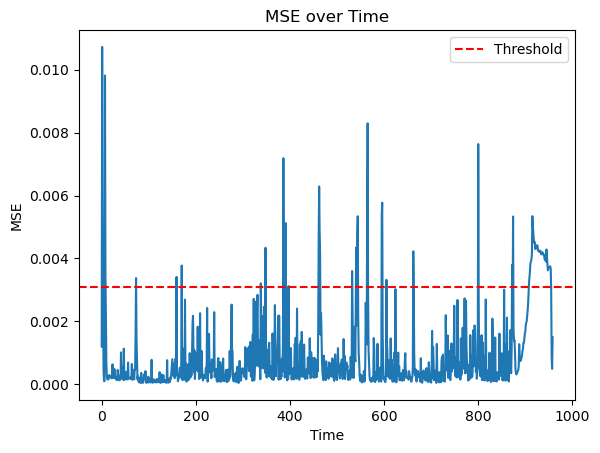

In [ ]:
plt.figure(figsize=(16, 6))

# 绘制 MSE 曲线
plt.plot(mse_values, color='black', linewidth=1, label='Reconstruction MSE')

# 计算阈值（参考原脚本）
alpha = 0.05
thred_b = np.mean(mse_values) + alpha * np.std(mse_values)
plt.axhline(y=thred_b, color='red', linestyle='--', label=f'Threshold ({thred_b:.4f})')

# --- 核心修改：添加阶段背景色 ---
# 使用 matplotlib 的 tab10 调色板
cmap = plt.get_cmap('tab10') 

# 遍历 stage 数组，找到每个阶段的起始和结束点
current_stage = test_stages[0]
start_idx = 0

# 为了在图例中只显示一次每个阶段，使用字典记录
stages_plotted = {}

for i in range(1, len(test_stages)):
    if test_stages[i] != current_stage:
        # 阶段发生变化，绘制上一个阶段的背景区域
        end_idx = i
        label = f'Stage {current_stage}'
        
        # 仅当该阶段未添加过标签时才添加 label，否则 label=None
        plot_label = label if current_stage not in stages_plotted else None
        
        plt.axvspan(start_idx, end_idx, facecolor=cmap(current_stage), alpha=0.2, label=plot_label)
        
        if plot_label:
            stages_plotted[current_stage] = True
            
        # 更新状态
        current_stage = test_stages[i]
        start_idx = i

# 绘制最后一个阶段
label = f'Stage {current_stage}'
plot_label = label if current_stage not in stages_plotted else None
plt.axvspan(start_idx, len(test_stages)-1, facecolor=cmap(current_stage), alpha=0.2, label=plot_label)

plt.title('Anomaly Score (MSE) over Time with Process Stages', fontsize=14)
plt.xlabel(f'Time Step (Index {test_start} - {test_end})', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)

# 整理图例：将 Stage 的图例按顺序排列
handles, labels = plt.gca().get_legend_handles_labels()
# 简单的排序逻辑，把 Stage 放到后面
by_label = dict(zip(labels, handles))
sorted_labels = sorted(by_label.keys(), key=lambda x: (x.startswith('Stage'), x))
sorted_handles = [by_label[l] for l in sorted_labels]

plt.legend(sorted_handles, sorted_labels, loc='upper right', frameon=True, ncol=2)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

# 打印异常统计
anomaly_count = np.sum(mse_values > thred_b)
print(f'Number of anomalies detected: {anomaly_count}')